In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from PIL import Image, ImageOps
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
# ⬆️  near your other imports
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# image directory
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
# get 10 images
image_files = os.listdir(image_dir)[:10]

for i, file_name in enumerate(image_files, 1):
    # iterate over the image files that get and
    # join the path to open each image
    image_path = os.path.join(image_dir, file_name)
    with Image.open(image_path) as img:
        print(f"Image {i}: {file_name} - Size: {img.size}") 

Random Seed:  999
Image 1: ISIC_9730802.jpg - Size: (139, 139)
Image 2: ISIC_2834883.jpg - Size: (125, 125)
Image 3: ISIC_5115027.jpg - Size: (123, 123)
Image 4: ISIC_3264822.jpg - Size: (115, 115)
Image 5: ISIC_1950204.jpg - Size: (147, 147)
Image 6: ISIC_8411738.jpg - Size: (145, 145)
Image 7: ISIC_3744117.jpg - Size: (133, 133)
Image 8: ISIC_0989720.jpg - Size: (131, 131)
Image 9: ISIC_3926794.jpg - Size: (139, 139)
Image 10: ISIC_2892810.jpg - Size: (107, 107)


In [5]:
meta_dir = "/kaggle/input/isic-2024-challenge/"

# read the csv file
df = pd.read_csv(meta_dir + "train-metadata.csv")

# display head
df.head()

isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3D: white  20.244422  ...   
1                    1.10  TBP tile: close-up     3D: white  31.712570  ...   
2                    3.40  TBP tile: close-up        3D: XP  22.575830  ...   
3                    3.22  TBP tile: close-up        3D: XP  14.242329  ...   
4                    2.73  TBP tile: close-up     3D: white  24.725520  ...   

    lesion_id  iddx_full  iddx_1  iddx_2  iddx_3  iddx_4  iddx_5  \
0         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
1  IL_6727506     Benign  Benign     NaN     NaN     NaN     NaN   
2         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
3         NaN     Benign  Benign     NaN     NaN     NaN     NaN   
4         NaN     Benign  Benign     NaN     NaN     NaN     NaN   

   mel_mitotic_index  mel_thick_mm  tbp_lv_dnn_lesion_confidence  
0                NaN           NaN                     97.517282  
1                NaN           NaN                      3.141455  
2                NaN           NaN                     99.804040  
3                NaN           NaN                     99.989998  
4                NaN           NaN                     70.442510  

[5 rows x 55 columns]

In [6]:
# for training the encoder we need only positive cases
# so others are drop by the dataframe
df_filtered = df[df["target"] == 1].reset_index(drop=True)

# show the new data frame
df_filtered.head()

isic_id  target  patient_id  age_approx     sex anatom_site_general  \
0  ISIC_0082829       1  IP_3249371        80.0  female      anterior torso   
1  ISIC_0096034       1  IP_6723298        75.0    male           head/neck   
2  ISIC_0104229       1  IP_9057861        80.0    male      anterior torso   
3  ISIC_0119495       1  IP_6856511        60.0    male     upper extremity   
4  ISIC_0157834       1  IP_3927284        55.0    male     posterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    9.27  TBP tile: close-up        3D: XP  18.093368  ...   
1                    3.88  TBP tile: close-up     3D: white  26.187010  ...   
2                    6.55  TBP tile: close-up     3D: white  33.480140  ...   
3                    5.27  TBP tile: close-up     3D: white  25.872050  ...   
4                    5.29  TBP tile: close-up     3D: white  30.966662  ...   

    lesion_id                                          iddx_full     iddx_1  \
0  IL_7881385  Malignant::Malignant epidermal proliferations:...  Malignant   
1  IL_5240575  Malignant::Malignant adnexal epithelial prolif...  Malignant   
2  IL_1702337  Malignant::Malignant adnexal epithelial prolif...  Malignant   
3  IL_3266850  Malignant::Malignant epidermal proliferations:...  Malignant   
4  IL_2429082  Malignant::Malignant adnexal epithelial prolif...  Malignant   

                                              iddx_2  \
0                 Malignant epidermal proliferations   
1  Malignant adnexal epithelial proliferations - ...   
2  Malignant adnexal epithelial proliferations - ...   
3                 Malignant epidermal proliferations   
4  Malignant adnexal epithelial proliferations - ...   

                              iddx_3                             iddx_4  \
0    Squamous cell carcinoma in situ                                NaN   
1               Basal cell carcinoma      Basal cell carcinoma, Nodular   
2               Basal cell carcinoma      Basal cell carcinoma, Nodular   
3  Squamous cell carcinoma, Invasive                                NaN   
4               Basal cell carcinoma  Basal cell carcinoma, Superficial   

   iddx_5  mel_mitotic_index  mel_thick_mm  tbp_lv_dnn_lesion_confidence  
0     NaN                NaN           NaN                     72.211683  
1     NaN                NaN           NaN                     94.559590  
2     NaN                NaN           NaN                     66.196170  
3     NaN                NaN           NaN                     99.991270  
4     NaN                NaN           NaN                     99.960846  

[5 rows x 55 columns]

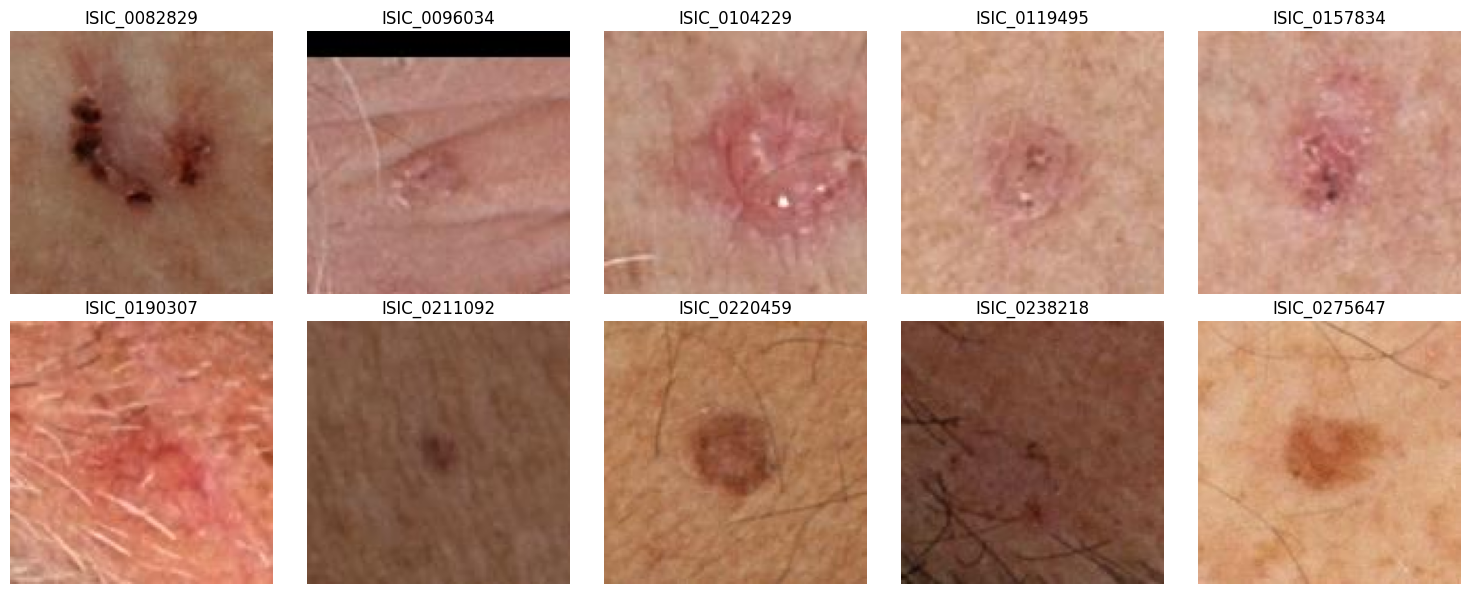

In [7]:
import matplotlib.pyplot as plt

# get first 10 isic_ids as sample and view them 
isic_ids = df_filtered['isic_id'].head(10)

# plot the images
plt.figure(figsize=(15, 6))
for i, isic_id in enumerate(isic_ids):
    image_path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = Image.open(image_path).convert("RGB")
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

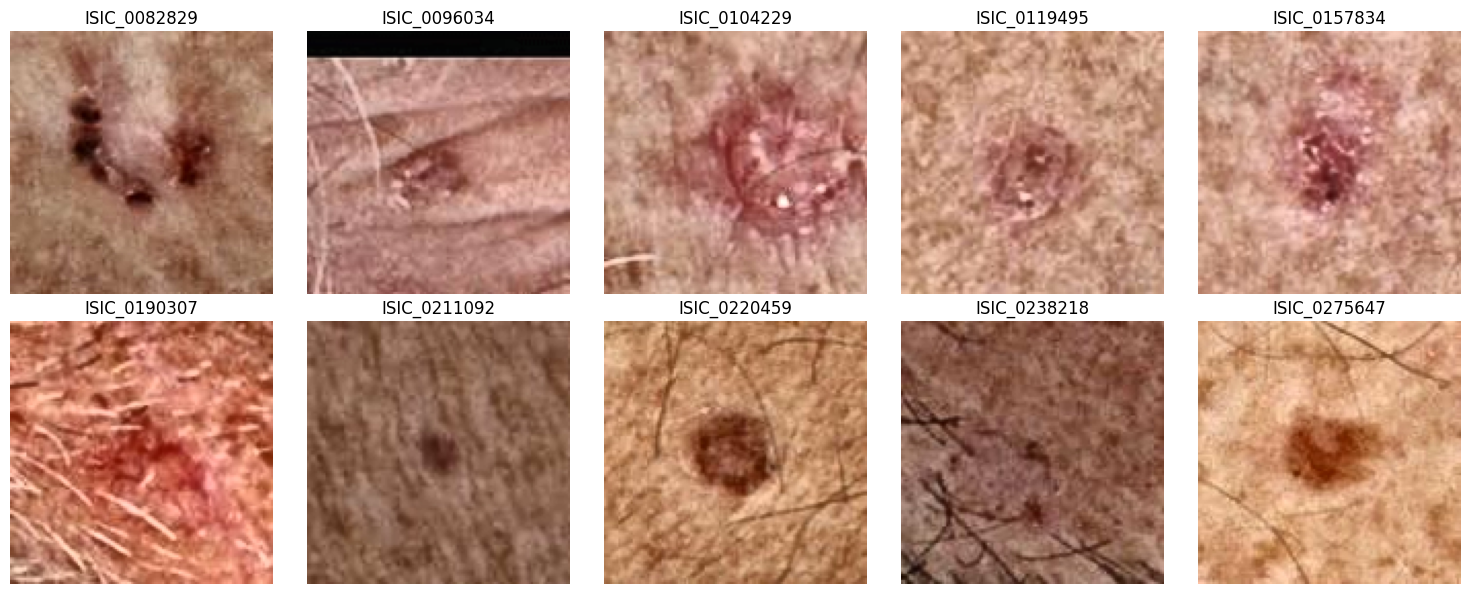

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/clahe_images'
os.makedirs(save_dir, exist_ok=True)

# Sample image IDs
isic_ids = df_filtered['isic_id'].head(10)

plt.figure(figsize=(15, 6))

for i, isic_id in enumerate(isic_ids):
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = cv2.imread(path)
    if img is None:
        continue  # skip if image not found

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

    # Convert to YUV and apply CLAHE on the luminance channel
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y_channel = yuv[:, :, 0]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    y_clahe = clahe.apply(y_channel)
    yuv[:, :, 0] = y_clahe

    # Convert back to RGB
    clahe_img = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

    # Save (convert back to BGR for OpenCV)
    save_path = os.path.join(save_dir, f"{isic_id}_clahe.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(clahe_img, cv2.COLOR_RGB2BGR))

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(clahe_img)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

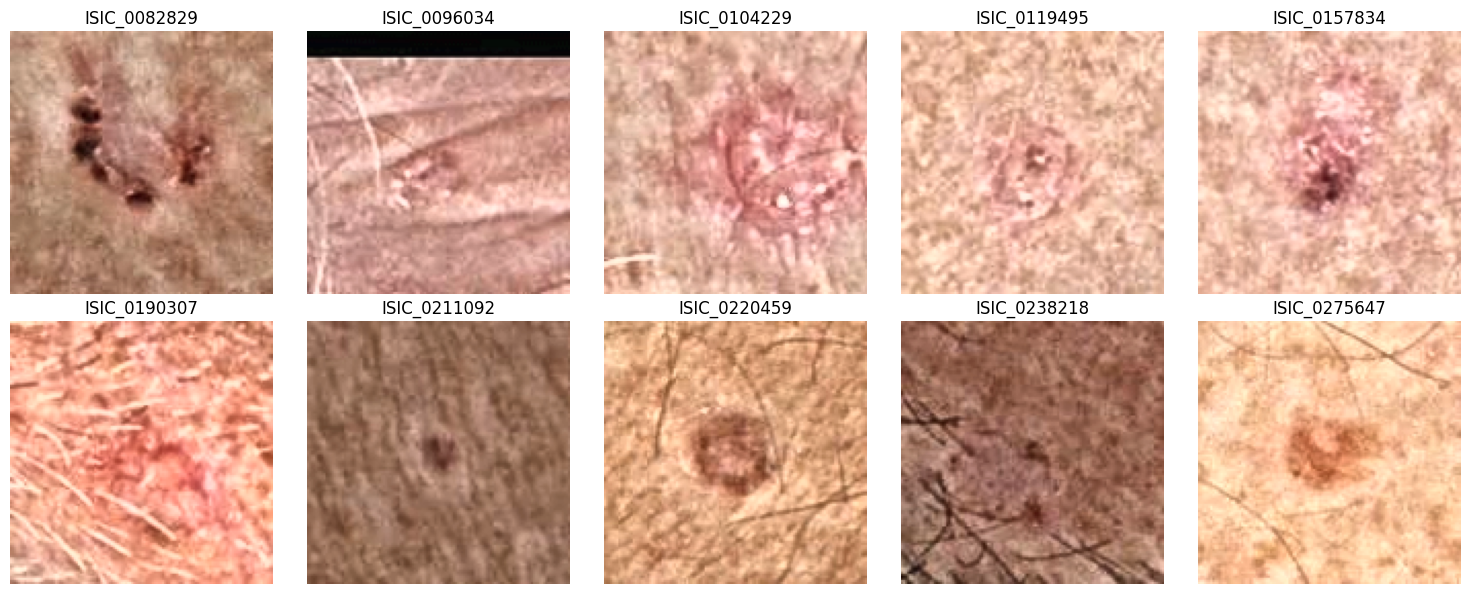

In [9]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/clahe_images_lab'
os.makedirs(save_dir, exist_ok=True)

# Sample image IDs
isic_ids = df_filtered['isic_id'].head(10)

plt.figure(figsize=(15, 6))

for i, isic_id in enumerate(isic_ids):
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = cv2.imread(path)
    if img is None:
        continue

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

    # Convert to Lab color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    # Merge and convert back to RGB
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2RGB)

    # Save (convert to BGR for OpenCV)
    save_path = os.path.join(save_dir, f"{isic_id}_clahe.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(img_clahe, cv2.COLOR_RGB2BGR))

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_clahe)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 54.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 24.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


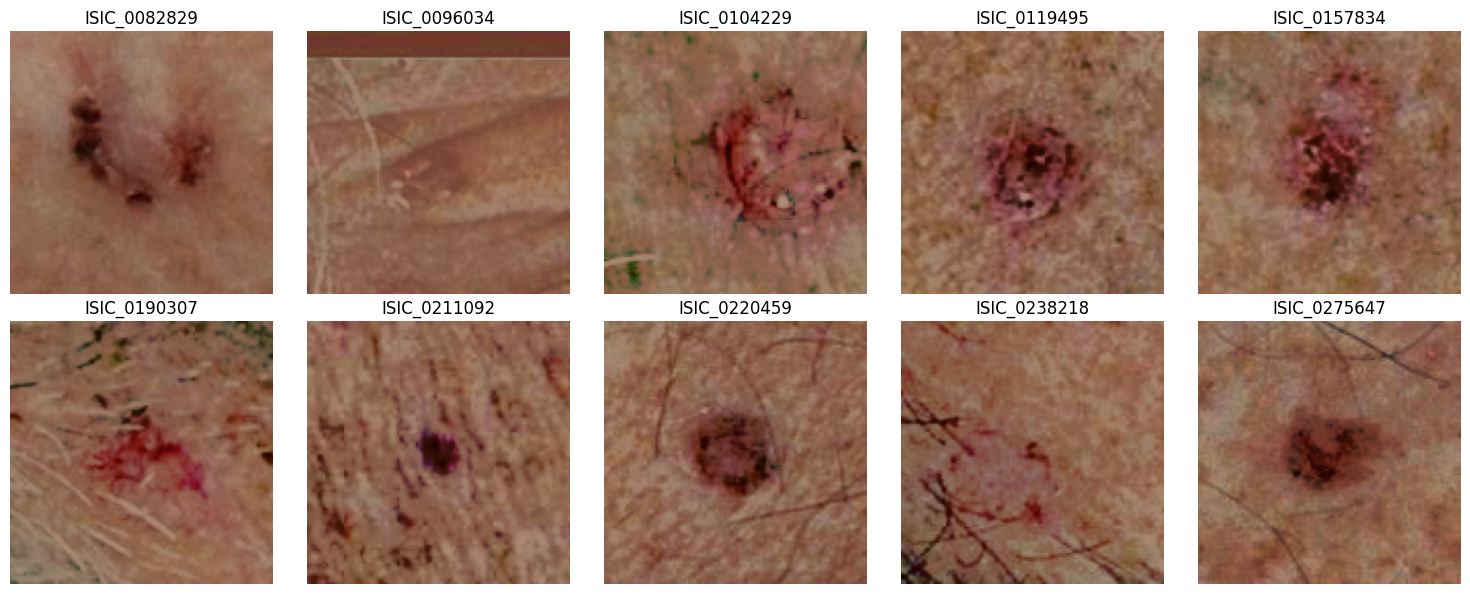

In [11]:
import os
import cv2
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

# Paths
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/histogram_matched_images'
os.makedirs(save_dir, exist_ok=True)

# Sample image IDs
isic_ids = df_filtered['isic_id'].head(10)

# Reference image (choose a well-lit image ID from your dataset)
reference_id = df_filtered['isic_id'].iloc[0]  # Use first image as reference
ref_path = os.path.join(image_dir, f"{reference_id}.jpg")
ref = cv2.imread(ref_path)
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
ref = cv2.resize(ref, (128, 128), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(15, 6))

for i, isic_id in enumerate(isic_ids):
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = cv2.imread(path)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

    # Match histogram to the reference image
    matched = match_histograms(img, ref, channel_axis=-1)

    # Save (convert to BGR for OpenCV)
    save_path = os.path.join(save_dir, f"{isic_id}_matched.jpg")
    cv2.imwrite(save_path, cv2.cvtColor((matched * 255).astype('uint8'), cv2.COLOR_RGB2BGR))

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(matched)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

**without clahe**

In [9]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# def remove_hairs(img):
#     """Apply DullRazor technique for hair removal on RGB image."""
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
#     blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
#     bhg = cv2.GaussianBlur(blackhat, (3, 3), 0)
#     _, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
#     dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
#     return dst

image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/without_any'
os.makedirs(save_dir, exist_ok=True)

# keep all malignant and 10,000 benign
malignant_df = df[df["target"] == 1]
benign_df = df[df["target"] == 0].sample(n=10000, random_state=42)
df_filtered = pd.concat([malignant_df, benign_df]).reset_index(drop=True)

# Store all records including augmented ones
new_records = []

def augment_image(img):
    aug_imgs = []
    for angle in [90, 180, 270]:
        rotated = cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        aug_imgs.append(rotated)
        aug_imgs.append(cv2.flip(rotated, 1))  # horizontal flip
    return aug_imgs

for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    isic_id = row["isic_id"]
    label = row["target"]
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))

    # ✅ Apply hair removal
    #img = remove_hairs(img)

    # Convert back to BGR before saving with OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Save processed image
    out_path = os.path.join(save_dir, f"{isic_id}.jpg")
    cv2.imwrite(out_path, img)
    new_records.append({'isic_id': isic_id, 'target': label})

    # Augment if malignant
    if label == 1:
        aug_imgs = augment_image(img)
        for i, aug_img in enumerate(aug_imgs):
            aug_id = f"{isic_id}_aug{i}"
            aug_path = os.path.join(save_dir, f"{aug_id}.jpg")
            cv2.imwrite(aug_path, aug_img)
            new_records.append({'isic_id': aug_id, 'target': 1})

# Create final DataFrame
df_filtered = pd.DataFrame(new_records).reset_index(drop=True)
print(f"Final dataset size: {len(df_filtered)}")
df_filtered.head()

100%|██████████| 10393/10393 [01:09<00:00, 150.15it/s]


Final dataset size: 12751


isic_id  target
0       ISIC_0082829       1
1  ISIC_0082829_aug0       1
2  ISIC_0082829_aug1       1
3  ISIC_0082829_aug2       1
4  ISIC_0082829_aug3       1

In [12]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        isic_id = self.df.iloc[idx]["isic_id"]
        label = self.df.iloc[idx]["target"]
        img_path = os.path.join(self.img_dir, f"{isic_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["target"], random_state=42)

train_dataset = SkinLesionDataset(train_df, save_dir, transform)
val_dataset = SkinLesionDataset(val_df, save_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [14]:
class EfficientNetBinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # load EfficientNet‑B0 backbone
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = efficientnet_b0(weights=weights)

        # replace the default classifier → single logit
        in_feats = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(in_feats, 1)
        )

    def forward(self, x):
        return self.backbone(x)          # raw logits (B, 1)

In [15]:
import matplotlib.pyplot as plt

def show_before_after(isic_ids, original_dir, processed_dir):
    """Display before/after images side by side."""
    plt.figure(figsize=(12, 10))
    for i, isic_id in enumerate(isic_ids):
        # Load original
        orig_path = os.path.join(original_dir, f"{isic_id}.jpg")
        orig_img = cv2.imread(orig_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # Load processed
        proc_path = os.path.join(processed_dir, f"{isic_id}.jpg")
        proc_img = cv2.imread(proc_path)
        proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)

        # Show original
        plt.subplot(len(isic_ids), 2, 2 * i + 1)
        plt.imshow(orig_img)
        plt.title(f"Original - {isic_id}")
        plt.axis("off")

        # Show processed
        plt.subplot(len(isic_ids), 2, 2 * i + 2)
        plt.imshow(proc_img)
        plt.title(f"Hair Removed - {isic_id}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example: Select 5 image IDs from your df_filtered
sample_ids = df_filtered[df_filtered["isic_id"].str.contains("aug") == False]["isic_id"].iloc[5:10].tolist()

# Set your original and processed image folders
original_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
processed_dir = '/kaggle/working/without_any'  # Or the directory with hair-removed images

# Display before-after comparisons
show_before_after(sample_ids, original_dir, processed_dir)

[ WARN:0@41.973] global loadsave.cpp:268 findDecoder imread_('/kaggle/working/without_any/ISIC_0190307.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


<Figure size 1200x1000 with 0 Axes>

In [16]:
import torch
import torch.nn as nn

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetBinaryClassifier(pretrained=True).to(device)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 123MB/s] 


In [17]:
print("📊 Image count by class (before training):")
print(df_filtered['target'].value_counts())

📊 Image count by class (before training):
target
1    393
Name: count, dtype: int64


In [16]:
from sklearn.metrics import accuracy_score
import torch

for epoch in range(10):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        # Compute training accuracy
        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        train_preds.extend(preds.flatten())
        train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            val_preds.extend(preds.flatten())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1: Train Loss = 0.4046, Train Acc = 0.8256, Val Loss = 0.2454, Val Acc = 0.9012
Epoch 2: Train Loss = 0.2014, Train Acc = 0.9232, Val Loss = 0.1742, Val Acc = 0.9330
Epoch 3: Train Loss = 0.1243, Train Acc = 0.9544, Val Loss = 0.1306, Val Acc = 0.9537
Epoch 4: Train Loss = 0.0807, Train Acc = 0.9747, Val Loss = 0.1109, Val Acc = 0.9600
Epoch 5: Train Loss = 0.0501, Train Acc = 0.9863, Val Loss = 0.0867, Val Acc = 0.9624
Epoch 6: Train Loss = 0.0376, Train Acc = 0.9877, Val Loss = 0.0965, Val Acc = 0.9639
Epoch 7: Train Loss = 0.0339, Train Acc = 0.9891, Val Loss = 0.0852, Val Acc = 0.9686
Epoch 8: Train Loss = 0.0251, Train Acc = 0.9921, Val Loss = 0.0883, Val Acc = 0.9679
Epoch 9: Train Loss = 0.0223, Train Acc = 0.9936, Val Loss = 0.0819, Val Acc = 0.9698
Epoch 10: Train Loss = 0.0243, Train Acc = 0.9919, Val Loss = 0.1075, Val Acc = 0.9671


Epoch 1: Train Loss = 0.4100, Train Acc = 0.8288, Val Loss = 0.3499, Val Acc = 0.8648

Epoch 2: Train Loss = 0.3448, Train Acc = 0.8594, Val Loss = 0.3097, Val Acc = 0.8753

Epoch 3: Train Loss = 0.3385, Train Acc = 0.8654, Val Loss = 0.3027, Val Acc = 0.8851

Epoch 4: Train Loss = 0.3320, Train Acc = 0.8671, Val Loss = 0.3041, Val Acc = 0.8753

Epoch 5: Train Loss = 0.3178, Train Acc = 0.8720, Val Loss = 0.2887, Val Acc = 0.8828

Epoch 1: Train Loss = 0.4042, Train Acc = 0.8247, Val Loss = 0.2591, Val Acc = 0.8965

Epoch 2: Train Loss = 0.2177, Train Acc = 0.9122, Val Loss = 0.1809, Val Acc = 0.9314

Epoch 3: Train Loss = 0.1382, Train Acc = 0.9512, Val Loss = 0.1577, Val Acc = 0.9353

Epoch 4: Train Loss = 0.0898, Train Acc = 0.9716, Val Loss = 0.1297, Val Acc = 0.9483

Epoch 5: Train Loss = 0.0615, Train Acc = 0.9820, Val Loss = 0.1226, Val Acc = 0.9526

hair removal , efficient net

Epoch 1: Train Loss = 0.4046, Train Acc = 0.8256, Val Loss = 0.2454, Val Acc = 0.9012

Epoch 2: Train Loss = 0.2014, Train Acc = 0.9232, Val Loss = 0.1742, Val Acc = 0.9330

Epoch 3: Train Loss = 0.1243, Train Acc = 0.9544, Val Loss = 0.1306, Val Acc = 0.9537

Epoch 4: Train Loss = 0.0807, Train Acc = 0.9747, Val Loss = 0.1109, Val Acc = 0.9600

Epoch 5: Train Loss = 0.0501, Train Acc = 0.9863, Val Loss = 0.0867, Val Acc = 0.9624

clahe Normal

In [17]:
import numpy as np
import cv2

def remove_hairs_v2(img):
    """
    Improved version of custom hair removal based on morphology, contour masking,
    and mean color thresholding. 
    Returns cleaned RGB image.
    """
    img = img.copy()
    kernel = np.ones((15,15), np.uint8)

    # Step 1: Morphological closing and blur to suppress hair
    closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    blurred = cv2.blur(closed, (15,15))

    # Step 2: Grayscale + OTSU binarization
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 3: Find largest contour (likely skin region)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  # Return original if no contour

    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, -1)

    # Step 4: Get mean color of skin region
    mean_color = cv2.mean(img, mask=mask)[:3]  # Ignore alpha
    mean_color = tuple(map(int, mean_color))

    # Step 5: Create final result — replace low color pixels inside region
    result = img.copy()
    h, w = img.shape[:2]
    for y in range(h):
        for x in range(w):
            if mask[y, x]:  # only inside the contour
                b, g, r = result[y, x]
                if r < mean_color[2]*0.8 or g < mean_color[1]*0.8 or b < mean_color[0]*0.8:
                    result[y, x] = mean_color

    return result

In [18]:
# import cv2
# import numpy as np

# def remove_hairs_dullrazor(img):
#     """
#     Advanced hair removal using morphological black-hat and inpainting (DullRazor).
#     Input: RGB image (uint8)
#     Output: Hair-removed RGB image
#     """
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     Step 1: Morphological black-hat to detecthair
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
#     blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

#     # Step 2: Threshold the blackhat image to get the hair mask
#     _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

#     # Step 3: Dilate the hair mask slightly to catch full hair strands
#     hair_mask = cv2.dilate(hair_mask, np.ones((3, 3), np.uint8), iterations=1)

#     # Step 4: Inpaint the image in RGB
#     inpainted = cv2.inpaint(img, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

#     return inpainted

In [19]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

def apply_clahe_yuv(img):
    """Apply CLAHE to the Y channel of an RGB image."""
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y_channel = yuv[:, :, 0]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    yuv[:, :, 0] = clahe.apply(y_channel)
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

def augment_image(img):
    """Return rotated and flipped versions of the image."""
    aug_imgs = []
    for angle in [90, 180, 270]:
        rotated = cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        aug_imgs.append(rotated)
        aug_imgs.append(cv2.flip(rotated, 1))  # Horizontal flip
    return aug_imgs

# === Setup Paths ===
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/clahe_images_lab'
os.makedirs(save_dir, exist_ok=True)

# === Load and Filter DataFrame ===
malignant_df = df[df["target"] == 1]
benign_df = df[df["target"] == 0].sample(n=10000, random_state=42)
df_filtered = pd.concat([malignant_df, benign_df]).reset_index(drop=True)

# === Process and Save Images ===
new_records = []

for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    isic_id = row["isic_id"]
    label = row["target"]
    img_path = os.path.join(image_dir, f"{isic_id}.jpg")
    save_path = os.path.join(save_dir, f"{isic_id}.jpg")

    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Failed to read: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    # ✅ Hair removal and CLAHE
    img = remove_hairs_v2(img)
    #img = remove_hairs_dullrazor(img)

    img = apply_clahe_yuv(img)

    # Save processed original
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    new_records.append({'isic_id': isic_id, 'target': label})

    # Augment if malignant
    if label == 1:
        aug_imgs = augment_image(img)
        for i, aug_img in enumerate(aug_imgs):
            aug_id = f"{isic_id}_aug{i}"
            aug_path = os.path.join(save_dir, f"{aug_id}.jpg")
            cv2.imwrite(aug_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            new_records.append({'isic_id': aug_id, 'target': 1})

# === Final DataFrame ===
df_filtered = pd.DataFrame(new_records).reset_index(drop=True)
print(f"✅ Final dataset size: {len(df_filtered)}")
df_filtered.head()

100%|██████████| 10393/10393 [19:02<00:00,  9.10it/s]


✅ Final dataset size: 12751


isic_id  target
0       ISIC_0082829       1
1  ISIC_0082829_aug0       1
2  ISIC_0082829_aug1       1
3  ISIC_0082829_aug2       1
4  ISIC_0082829_aug3       1

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["target"], random_state=42)

train_dataset = SkinLesionDataset(train_df, save_dir, transform)
val_dataset = SkinLesionDataset(val_df, save_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [21]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        isic_id = self.df.iloc[idx]["isic_id"]
        label = self.df.iloc[idx]["target"]
        img_path = os.path.join(self.img_dir, f"{isic_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # raw logits

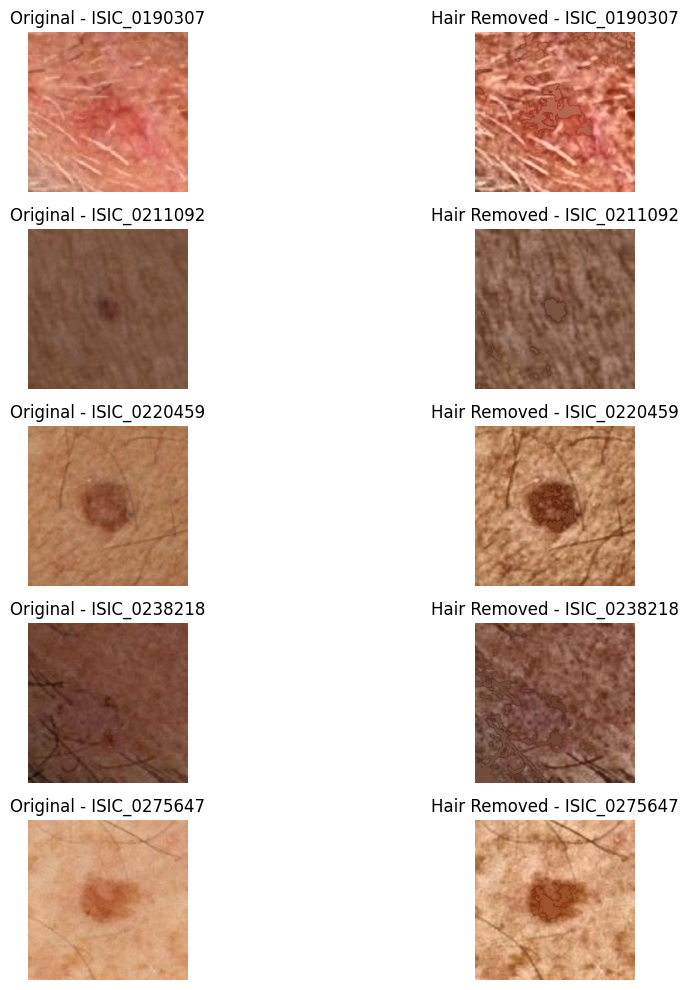

In [23]:
import matplotlib.pyplot as plt

def show_before_after(isic_ids, original_dir, processed_dir):
    """Display before/after images side by side."""
    plt.figure(figsize=(12, 10))
    for i, isic_id in enumerate(isic_ids):
        # Load original
        orig_path = os.path.join(original_dir, f"{isic_id}.jpg")
        orig_img = cv2.imread(orig_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # Load processed
        proc_path = os.path.join(processed_dir, f"{isic_id}.jpg")
        proc_img = cv2.imread(proc_path)
        proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)

        # Show original
        plt.subplot(len(isic_ids), 2, 2 * i + 1)
        plt.imshow(orig_img)
        plt.title(f"Original - {isic_id}")
        plt.axis("off")

        # Show processed
        plt.subplot(len(isic_ids), 2, 2 * i + 2)
        plt.imshow(proc_img)
        plt.title(f"Hair Removed - {isic_id}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example: Select 5 image IDs from your df_filtered
sample_ids = df_filtered[df_filtered["isic_id"].str.contains("aug") == False]["isic_id"].iloc[5:10].tolist()

# Set your original and processed image folders
original_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
processed_dir = '/kaggle/working/clahe_images_lab'

# Display before-after comparisons
show_before_after(sample_ids, original_dir, processed_dir)

In [24]:
print("📊 Image count by class (before training):")
print(df_filtered['target'].value_counts())

📊 Image count by class (before training):
target
0    10000
1     2751
Name: count, dtype: int64


In [25]:
from sklearn.metrics import accuracy_score
import torch

scheduler.step()

for epoch in range(5):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        # Compute training accuracy
        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        train_preds.extend(preds.flatten())
        train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            val_preds.extend(preds.flatten())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1: Train Loss = 0.2761, Train Acc = 0.9011, Val Loss = 0.1996, Val Acc = 0.9153
Epoch 2: Train Loss = 0.1695, Train Acc = 0.9331, Val Loss = 0.1447, Val Acc = 0.9443
Epoch 3: Train Loss = 0.1453, Train Acc = 0.9381, Val Loss = 0.1288, Val Acc = 0.9498
Epoch 4: Train Loss = 0.1262, Train Acc = 0.9483, Val Loss = 0.1032, Val Acc = 0.9584
Epoch 5: Train Loss = 0.1009, Train Acc = 0.9603, Val Loss = 0.1099, Val Acc = 0.9612


Epoch 1: Train Loss = 0.2761, Train Acc = 0.9011, Val Loss = 0.1996, Val Acc = 0.9153

Epoch 2: Train Loss = 0.1695, Train Acc = 0.9331, Val Loss = 0.1447, Val Acc = 0.9443

Epoch 3: Train Loss = 0.1453, Train Acc = 0.9381, Val Loss = 0.1288, Val Acc = 0.9498

Epoch 4: Train Loss = 0.1262, Train Acc = 0.9483, Val Loss = 0.1032, Val Acc = 0.9584

Epoch 5: Train Loss = 0.1009, Train Acc = 0.9603, Val Loss = 0.1099, Val Acc = 0.9612

clahe lab

In [18]:
# import cv2
# import numpy as np

# def remove_hairs_dullrazor(img):
#     """
#     Advanced hair removal using morphological black-hat and inpainting (DullRazor).
#     Input: RGB image (uint8)
#     Output: Hair-removed RGB image
#     """
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     #Step 1: Morphological black-hat to detecthair
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
#     blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

#     # Step 2: Threshold the blackhat image to get the hair mask
#     _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

#     # Step 3: Dilate the hair mask slightly to catch full hair strands
#     hair_mask = cv2.dilate(hair_mask, np.ones((3, 3), np.uint8), iterations=1)

#     # Step 4: Inpaint the image in RGB
#     inpainted = cv2.inpaint(img, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

#     return inpainted

In [19]:
import numpy as np
import cv2

def remove_hairs_v2(img):
    """
    Improved version of custom hair removal based on morphology, contour masking,
    and mean color thresholding. 
    Returns cleaned RGB image.
    """
    img = img.copy()
    kernel = np.ones((15,15), np.uint8)

    # Step 1: Morphological closing and blur to suppress hair
    closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    blurred = cv2.blur(closed, (15,15))

    # Step 2: Grayscale + OTSU binarization
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 3: Find largest contour (likely skin region)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  # Return original if no contour

    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, -1)

    # Step 4: Get mean color of skin region
    mean_color = cv2.mean(img, mask=mask)[:3]  # Ignore alpha
    mean_color = tuple(map(int, mean_color))

    # Step 5: Create final result — replace low color pixels inside region
    result = img.copy()
    h, w = img.shape[:2]
    for y in range(h):
        for x in range(w):
            if mask[y, x]:  # only inside the contour
                b, g, r = result[y, x]
                if r < mean_color[2]*0.8 or g < mean_color[1]*0.8 or b < mean_color[0]*0.8:
                    result[y, x] = mean_color

    return result

In [20]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

def apply_clahe_yuv(img):
    """Apply CLAHE to the Y channel of an RGB image."""
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y_channel = yuv[:, :, 0]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    yuv[:, :, 0] = clahe.apply(y_channel)
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

def augment_image(img):
    """Return rotated and flipped versions of the image."""
    aug_imgs = []
    for angle in [90, 180, 270]:
        rotated = cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        aug_imgs.append(rotated)
        aug_imgs.append(cv2.flip(rotated, 1))  # Horizontal flip
    return aug_imgs

# === Setup Paths ===
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/clahe_images_lab'
os.makedirs(save_dir, exist_ok=True)

# === Load and Filter DataFrame ===
malignant_df = df[df["target"] == 1]
benign_df = df[df["target"] == 0].sample(n=10000, random_state=42)
df_filtered = pd.concat([malignant_df, benign_df]).reset_index(drop=True)

# === Process and Save Images ===
new_records = []

for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    isic_id = row["isic_id"]
    label = row["target"]
    img_path = os.path.join(image_dir, f"{isic_id}.jpg")
    save_path = os.path.join(save_dir, f"{isic_id}.jpg")

    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Failed to read: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    # ✅ Apply Hair Removal
    #img = remove_hairs_dullrazor(img)

    # ✅ Apply CLAHE
    img = apply_clahe_yuv(img)

    img = remove_hairs_v2(img)
    
    # Save processed original
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    new_records.append({'isic_id': isic_id, 'target': label})

    # Augment if malignant
    if label == 1:
        aug_imgs = augment_image(img)
        for i, aug_img in enumerate(aug_imgs):
            aug_id = f"{isic_id}_aug{i}"
            aug_path = os.path.join(save_dir, f"{aug_id}.jpg")
            cv2.imwrite(aug_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            new_records.append({'isic_id': aug_id, 'target': 1})

# === Final DataFrame ===
df_filtered = pd.DataFrame(new_records).reset_index(drop=True)
print(f"✅ Final dataset size: {len(df_filtered)}")
df_filtered.head()

100%|██████████| 10393/10393 [12:41<00:00, 13.66it/s]


✅ Final dataset size: 12751


isic_id  target
0       ISIC_0082829       1
1  ISIC_0082829_aug0       1
2  ISIC_0082829_aug1       1
3  ISIC_0082829_aug2       1
4  ISIC_0082829_aug3       1

In [21]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["target"], random_state=42)

train_dataset = SkinLesionDataset(train_df, save_dir, transform)
val_dataset = SkinLesionDataset(val_df, save_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [22]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        isic_id = self.df.iloc[idx]["isic_id"]
        label = self.df.iloc[idx]["target"]
        img_path = os.path.join(self.img_dir, f"{isic_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # raw logits

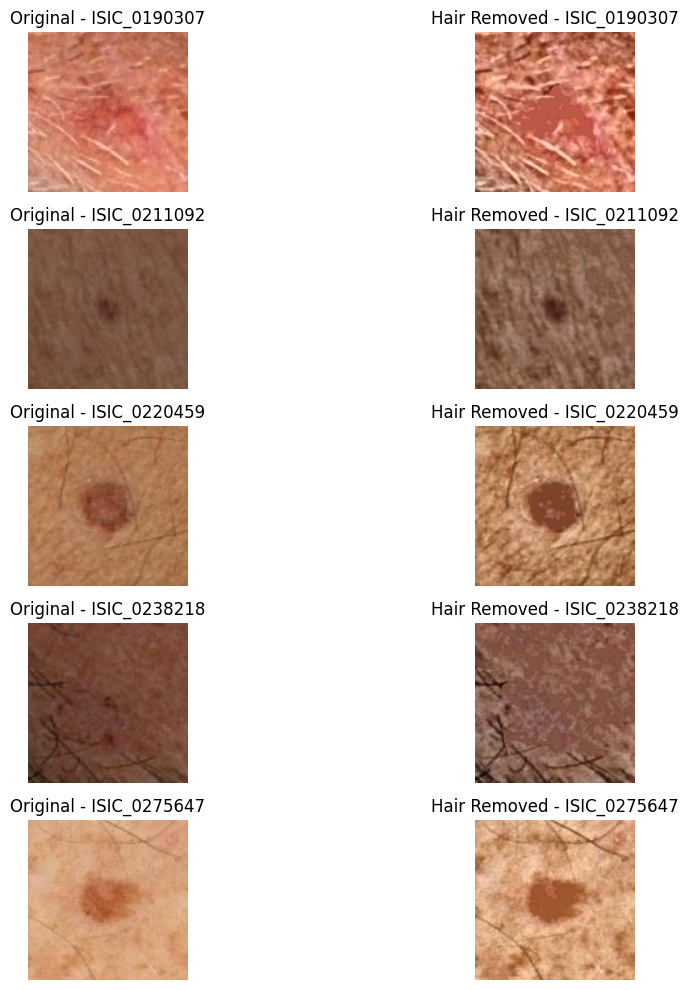

In [24]:
import matplotlib.pyplot as plt

def show_before_after(isic_ids, original_dir, processed_dir):
    """Display before/after images side by side."""
    plt.figure(figsize=(12, 10))
    for i, isic_id in enumerate(isic_ids):
        # Load original
        orig_path = os.path.join(original_dir, f"{isic_id}.jpg")
        orig_img = cv2.imread(orig_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # Load processed
        proc_path = os.path.join(processed_dir, f"{isic_id}.jpg")
        proc_img = cv2.imread(proc_path)
        proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)

        # Show original
        plt.subplot(len(isic_ids), 2, 2 * i + 1)
        plt.imshow(orig_img)
        plt.title(f"Original - {isic_id}")
        plt.axis("off")

        # Show processed
        plt.subplot(len(isic_ids), 2, 2 * i + 2)
        plt.imshow(proc_img)
        plt.title(f"Hair Removed - {isic_id}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example: Select 5 image IDs from your df_filtered
sample_ids = df_filtered[df_filtered["isic_id"].str.contains("aug") == False]["isic_id"].iloc[5:10].tolist()

# Set your original and processed image folders
original_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
processed_dir = '/kaggle/working/clahe_images_lab'  # Or the directory with hair-removed images

# Display before-after comparisons
show_before_after(sample_ids, original_dir, processed_dir)

In [25]:
print("📊 Image count by class (before training):")
print(df_filtered['target'].value_counts())

📊 Image count by class (before training):
target
0    10000
1     2751
Name: count, dtype: int64


In [27]:
from sklearn.metrics import accuracy_score
import torch

scheduler.step()

for epoch in range(10):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        # Compute training accuracy
        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        train_preds.extend(preds.flatten())
        train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            val_preds.extend(preds.flatten())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1: Train Loss = 0.0724, Train Acc = 0.9749, Val Loss = 0.0944, Val Acc = 0.9651
Epoch 2: Train Loss = 0.0611, Train Acc = 0.9791, Val Loss = 0.0722, Val Acc = 0.9726
Epoch 3: Train Loss = 0.0545, Train Acc = 0.9816, Val Loss = 0.0727, Val Acc = 0.9757
Epoch 4: Train Loss = 0.0461, Train Acc = 0.9840, Val Loss = 0.0875, Val Acc = 0.9726
Epoch 5: Train Loss = 0.0532, Train Acc = 0.9817, Val Loss = 0.0705, Val Acc = 0.9753
Epoch 6: Train Loss = 0.0448, Train Acc = 0.9855, Val Loss = 0.0754, Val Acc = 0.9741
Epoch 7: Train Loss = 0.0398, Train Acc = 0.9855, Val Loss = 0.0763, Val Acc = 0.9757
Epoch 8: Train Loss = 0.0340, Train Acc = 0.9881, Val Loss = 0.0717, Val Acc = 0.9757
Epoch 9: Train Loss = 0.0312, Train Acc = 0.9886, Val Loss = 0.0568, Val Acc = 0.9800
Epoch 10: Train Loss = 0.0342, Train Acc = 0.9880, Val Loss = 0.0731, Val Acc = 0.9765
